In [ ]:
!pip install biopython arxiv pandas tqdm


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 8.3 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6046 sha256=b75c5431f48c61e955fe07359efdaf59506040a6ec728d60649c284c1c308d09
  Stored in directory: /root/.cache/pip/wheels/03/f5/1a/23761066dac1d0e8e683e5fdb27e12de53209d05a4a37e6246
Successfully built sgmllib3k


In [ ]:
# === Structured search queries ===

DISEASE_TERMS = [
    '"Anaplastic Thyroid Carcinoma"',
    '"Undifferentiated Thyroid Carcinoma"',
    'ATC',
    '"Thyroid Neoplasms"[MeSH]'
]

DRUG_TERMS = [
    '"Pazopanib"',
    '"Sorafenib"',
    '"Cabozantinib"',
    '"Everolimus"',
    '"mTOR inhibitor"',
    '"VEGFR inhibitor"'
]

METHOD_TERMS = [
    '"drug repurposing"',
    '"drug repositioning"',
    '"knowledge graph"',
    '"hypothesis generation"',
    '"generative AI"'
]

# Build combinations
PUBMED_QUERIES = [
    f"({' OR '.join(DISEASE_TERMS)}) AND ({' OR '.join(DRUG_TERMS)}) AND ({' OR '.join(METHOD_TERMS)})",
    f"({' OR '.join(DISEASE_TERMS)}) AND ({' OR '.join(DRUG_TERMS)})",
    f"({' OR '.join(DISEASE_TERMS)}) AND ({' OR '.join(METHOD_TERMS)})"
]

ARXIV_QUERIES = [
    'all:"drug repurposing" AND (thyroid OR anaplastic)',
    'all:"knowledge graph" AND "drug repurposing"',
    'all:"generative AI" AND "drug discovery"'
]


In [ ]:
from Bio import Entrez
from tqdm import tqdm
import pandas as pd

Entrez.email = "nida.amir0083@gmail.com"  # REQUIRED
MAX_RESULTS = 300  # limit per query

def fetch_pubmed(query, max_results=200):
    handle = Entrez.esearch(db="pubmed", term=query, retmax=max_results)
    record = Entrez.read(handle)
    pmids = record["IdList"]

    results = []
    if not pmids:
        return results

    handle = Entrez.efetch(db="pubmed", id=",".join(pmids), rettype="abstract", retmode="xml")
    records = Entrez.read(handle)

    for article in records["PubmedArticle"]:
        try:
            title = article["MedlineCitation"]["Article"]["ArticleTitle"]
            abstract = ""
            if "Abstract" in article["MedlineCitation"]["Article"]:
                abstract = " ".join([str(x) for x in article["MedlineCitation"]["Article"]["Abstract"]["AbstractText"]])
            pmid = article["MedlineCitation"]["PMID"]
            journal = article["MedlineCitation"]["Article"]["Journal"]["Title"]
            results.append({
                "source": "PubMed",
                "id": str(pmid),
                "title": title,
                "abstract": abstract,
                "journal": journal,
                "query": query
            })
        except Exception as e:
            continue
    return results

# Run all PubMed queries
pubmed_results = []
for q in tqdm(PUBMED_QUERIES, desc="PubMed queries"):
    pubmed_results.extend(fetch_pubmed(q, MAX_RESULTS))

print(f"Total PubMed articles retrieved: {len(pubmed_results)}")


PubMed queries: 100%|██████████| 3/3 [00:05<00:00,  1.68s/it]

Total PubMed articles retrieved: 353


In [ ]:
import arxiv

def fetch_arxiv(query, max_results=100):
    search = arxiv.Search(
        query=query,
        max_results=max_results,
        sort_by=arxiv.SortCriterion.Relevance
    )
    results = []
    for r in search.results():
        results.append({
            "source": "arXiv",
            "id": r.entry_id.split("/")[-1],
            "title": r.title,
            "abstract": r.summary,
            "authors": [a.name for a in r.authors],
            "published": r.published.strftime("%Y-%m-%d"),
            "query": query
        })
    return results

# Run all arXiv queries
arxiv_results = []
for q in tqdm(ARXIV_QUERIES, desc="arXiv queries"):
    arxiv_results.extend(fetch_arxiv(q, 100))

print(f"Total arXiv papers retrieved: {len(arxiv_results)}")


arXiv queries:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipython-input-104173351.py:10: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  for r in search.results():
arXiv queries: 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]

Total arXiv papers retrieved: 50


In [ ]:
# Merge all results
all_results = pubmed_results + arxiv_results

df = pd.DataFrame(all_results)
print(f"Total combined documents: {len(df)}")

# Preview
df.head(10)


Total combined documents: 403


,source,id,title,abstract,journal,query,authors,published
0,PubMed,40938918,"Cabozantinib plus Atezolizumab in Advanced, Pr...",Multikinase inhibitors (MKIs) have shown effic...,Clinical cancer research : an official journal...,"(""Anaplastic Thyroid Carcinoma"" OR ""Undifferen...",NaN,NaN
1,PubMed,40877185,Evaluation of Altered Myocardial Blood Flow an...,This study aimed to explore changes in cardiov...,"In vivo (Athens, Greece)","(""Anaplastic Thyroid Carcinoma"" OR ""Undifferen...",NaN,NaN
2,PubMed,40880035,Systemic Therapy for Advanced Thyroid Cancer-N...,Tyrosine kinase inhibitors (TKIs) have revolut...,Drugs,"(""Anaplastic Thyroid Carcinoma"" OR ""Undifferen...",NaN,NaN
3,PubMed,40873805,Thyroid Fibrosarcoma as a Rare Differential Di...,<b>Introduction:</b> Thyroid gland fibrosarcom...,Case reports in endocrinology,"(""Anaplastic Thyroid Carcinoma"" OR ""Undifferen...",NaN,NaN
4,PubMed,40804316,LINC00162 silencing enhances sorafenib sensiti...,Many studies have reported the aberrant expres...,Scientific reports,"(""Anaplastic Thyroid Carcinoma"" OR ""Undifferen...",NaN,NaN
5,PubMed,40742350,Targeting RET in medullary thyroid cancer.,Medullary thyroid cancer (MTC) is a rare cance...,Endocrine-related cancer,"(""Anaplastic Thyroid Carcinoma"" OR ""Undifferen...",NaN,NaN
6,PubMed,40600748,Involvement of KEAP1/NRF2 pathway in non-BRAF ...,Squamous cell carcinoma (SCC) of the thyroid i...,The Journal of pathology,"(""Anaplastic Thyroid Carcinoma"" OR ""Undifferen...",NaN,NaN
7,PubMed,40591429,[Renal cell carcinoma metastasis to the thyroi...,Renal cell carcinoma may be associated with hi...,Revista de la Facultad de Ciencias Medicas (Co...,"(""Anaplastic Thyroid Carcinoma"" OR ""Undifferen...",NaN,NaN
8,PubMed,40507982,"Thyroid Cancer: Epidemiology, Classification, ...",Thyroid cancer (TC) invariably remains the mos...,International journal of molecular sciences,"(""Anaplastic Thyroid Carcinoma"" OR ""Undifferen...",NaN,NaN
9,PubMed,40345488,ENDOCAN TUTHYREF network consensus recommendat...,Radioactive-iodine-refractory differentiated t...,Annales d'endocrinologie,"(""Anaplastic Thyroid Carcinoma"" OR ""Undifferen...",NaN,NaN


In [ ]:
import re

def normalize_title(title: str) -> str:
    if not title:
        return ""
    t = re.sub(r'\s+', ' ', title).strip().lower()
    t = re.sub(r'[^\w\s]', '', t)  # remove punctuation
    return t

# Deduplicate by normalized title
df["norm_title"] = df["title"].apply(normalize_title)
before = len(df)
df = df.drop_duplicates(subset="norm_title", keep="first").reset_index(drop=True)
after = len(df)

print(f"Deduplicated: {before - after} duplicates removed")
print(f"Remaining unique documents: {after}")


Deduplicated: 2 duplicates removed
Remaining unique documents: 401


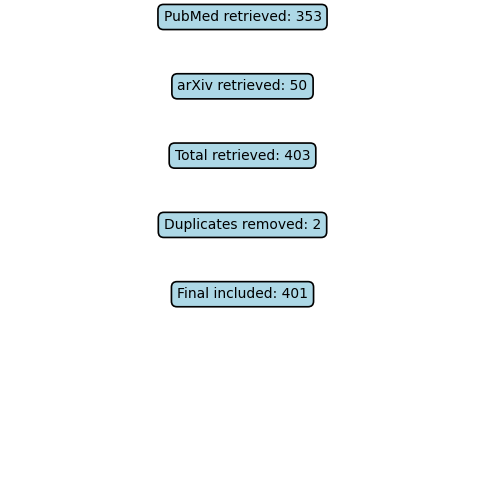

In [ ]:
import matplotlib.pyplot as plt

# Example numbers (replace with real counts from your pipeline)
retrieved_pubmed = len(pubmed_results)
retrieved_arxiv = len(arxiv_results)
retrieved_total = retrieved_pubmed + retrieved_arxiv
deduplicated_removed = before - after
final_included = after

# Build flow numbers
flow_data = {
    "PubMed retrieved": retrieved_pubmed,
    "arXiv retrieved": retrieved_arxiv,
    "Total retrieved": retrieved_total,
    "Duplicates removed": deduplicated_removed,
    "Final included": final_included
}

# Simple PRISMA-like flowchart
fig, ax = plt.subplots(figsize=(6,6))
ax.axis("off")

y = 1.0
for step, val in flow_data.items():
    ax.text(0.5, y, f"{step}: {val}", ha="center", va="center",
            bbox=dict(boxstyle="round,pad=0.4", fc="lightblue", ec="black", lw=1.2))
    y -= 0.15

plt.show()


In [ ]:
# Save the cleaned DataFrame to CSV/JSON for downstream steps
df.to_csv("retrieved_articles_clean.csv", index=False)
df.to_json("retrieved_articles_clean.json", orient="records", lines=True)

print("Saved cleaned dataset for downstream processing.")


Saved cleaned dataset for downstream processing.


In [ ]:
!pip install transformers sentence-transformers scikit-learn


In [ ]:
import re
import numpy as np
from datetime import datetime
from sklearn.preprocessing import minmax_scale
from transformers import AutoTokenizer, AutoModel
import torch

# Candidate drugs and disease keywords
DISEASE_KEYWORDS = ["anaplastic thyroid carcinoma", "undifferentiated thyroid carcinoma", "ATC"]
DRUG_KEYWORDS = ["pazopanib", "sorafenib", "cabozantinib", "everolimus", "mtor inhibitor", "vegfr inhibitor"]

# Load BioBERT for embeddings
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
model = AutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

def embed_text(text):
    if not text:
        return np.zeros(768)
    inputs = tokenizer(text[:512], return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [ ]:
# Normalize year (recency)
CURRENT_YEAR = datetime.now().year

def compute_features(row):
    text = (row["title"] or "") + " " + (row["abstract"] or "")
    text_low = text.lower()

    # Feature 1: Recency (if published date exists)
    year = None
    if "published" in row and pd.notna(row["published"]):
        try:
            year = int(str(row["published"])[:4])
        except:
            year = None
    recency = (year - 2000) / (CURRENT_YEAR - 2000) if year and year > 2000 else 0.5

    # Feature 2: Disease mention
    disease_mention = int(any(k in text_low for k in DISEASE_KEYWORDS))

    # Feature 3: Drug mention
    drug_mention = int(any(k in text_low for k in DRUG_KEYWORDS))

    # Feature 4: Source weight
    source_weight = 1.0 if row["source"] == "PubMed" else 0.8

    return pd.Series({
        "recency": recency,
        "disease_mention": disease_mention,
        "drug_mention": drug_mention,
        "source_weight": source_weight
    })

df_features = df.apply(compute_features, axis=1)
df = pd.concat([df, df_features], axis=1)


In [ ]:
# Embed the disease query
query_embedding = embed_text("Anaplastic Thyroid Carcinoma drug repurposing")

def compute_similarity(row):
    text = (row["title"] or "") + " " + (row["abstract"] or "")
    emb = embed_text(text)
    sim = np.dot(query_embedding, emb) / (np.linalg.norm(query_embedding) * np.linalg.norm(emb) + 1e-8)
    return sim

df["embedding_similarity"] = df.apply(compute_similarity, axis=1)


In [ ]:
# Normalize features
df["recency_norm"] = minmax_scale(df["recency"])
df["embedding_norm"] = minmax_scale(df["embedding_similarity"])

# Composite score (tunable weights)
df["composite_score"] = (
    0.25 * df["recency_norm"] +
    0.20 * df["disease_mention"] +
    0.20 * df["drug_mention"] +
    0.15 * df["source_weight"] +
    0.20 * df["embedding_norm"]
)

# Sort by score
df_ranked = df.sort_values("composite_score", ascending=False).reset_index(drop=True)
df_ranked[["title", "source", "recency_norm", "disease_mention", "drug_mention", "embedding_norm", "composite_score"]].head(10)


,title,source,recency_norm,disease_mention,drug_mention,embedding_norm,composite_score
0,Construction of an anaplastic thyroid cancer s...,PubMed,0.0,1.0,1.0,0.911631,0.732326
1,An Era of Advances in Systemic Therapies for A...,PubMed,0.0,1.0,1.0,0.887549,0.727510
2,Distribution and Activity of Lenvatinib in Bra...,PubMed,0.0,1.0,1.0,0.881928,0.726386
3,Mortalin (GRP75/HSPA9) Promotes Survival and P...,PubMed,0.0,1.0,1.0,0.880243,0.726049
4,Synergic Induction of Autophagic Cell Death in...,PubMed,0.0,1.0,1.0,0.864153,0.722831
5,Targeting Aurora-A inhibits tumor progression ...,PubMed,0.0,1.0,1.0,0.849867,0.719973
6,Effect of mesoporous silica nanoparticles co‑l...,PubMed,0.0,1.0,1.0,0.846191,0.719238
7,The curcumin analogue PAC has potent anti-anap...,PubMed,0.0,1.0,1.0,0.824044,0.714809
8,A Systematic Review of Phase II Targeted Thera...,PubMed,0.0,1.0,1.0,0.823104,0.714621
9,Novel treatments for anaplastic thyroid carcin...,PubMed,0.0,1.0,1.0,0.807041,0.711408


In [ ]:
# Save top 50 results as evidence table
evidence_table = df_ranked.head(50)
evidence_table.to_csv("evidence_table.csv", index=False)

print("Saved top 50 evidence-ranked articles to evidence_table.csv")


Saved top 50 evidence-ranked articles to evidence_table.csv
